In [45]:
!pip install fairlearn
!pip install imblearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

from sklearn.datasets import fetch_openml
from fairlearn.preprocessing import CorrelationRemover

from imblearn.metrics import geometric_mean_score

In [47]:
data = fetch_openml(data_id=43874, as_frame=True)
# https://www.openml.org/search?type=data&status=active&id=43874

X_raw = data.data[["race", "time_in_hospital", "had_inpatient_days", "medicare"]]
X_raw = pd.get_dummies(X_raw)
y = data.target

X_raw = X_raw.drop(["race_Asian",
                    'race_Caucasian',
                    'race_Hispanic',
                    'race_Other',
                    'race_Unknown',
                    'had_inpatient_days_False',
                    'medicare_False'], axis=1)

X_raw = X_raw[['time_in_hospital', 'had_inpatient_days_True', 'medicare_True', 'race_AfricanAmerican']]

/usr/local/lib/python3.9/dist-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [48]:
sensitive_attr = "race_AfricanAmerican"
cr = CorrelationRemover(sensitive_feature_ids=[sensitive_attr])
X_cr = cr.fit_transform(X_raw)
X_cr = pd.DataFrame(X_cr, columns=['time_in_hospital', 'had_inpatient_days_True', 'medicare_True'])
X_cr[sensitive_attr] = X_raw[sensitive_attr]

cr_alpha = CorrelationRemover(sensitive_feature_ids=[sensitive_attr], alpha=0.5)
X_cr_alpha = cr_alpha.fit_transform(X_raw)
X_cr_alpha = pd.DataFrame(X_cr_alpha, columns=['time_in_hospital', 'had_inpatient_days_True', 'medicare_True'])
X_cr_alpha[sensitive_attr] = X_raw[sensitive_attr]

In [49]:
def plot_correlation_heatmap(df, title, **kwargs):
    corr = df.corr()
    heatmap = sns.heatmap(corr, annot=True, fmt='.2f', **kwargs)
    heatmap.set_xticklabels(heatmap.get_xticklabels(), ha='right', rotation=15)
    heatmap.set_title(title)

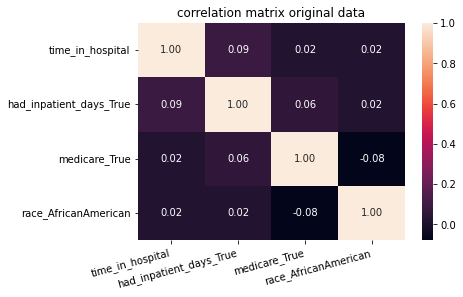

In [50]:
plot_correlation_heatmap(X_raw, f'correlation matrix original data')

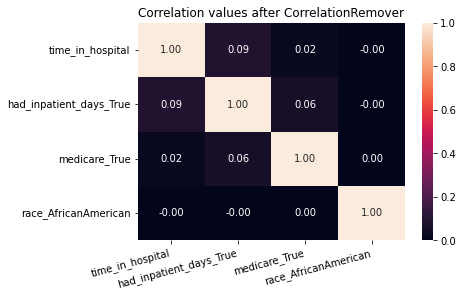

In [51]:
plot_correlation_heatmap(X_cr, f'Correlation values after CorrelationRemover')

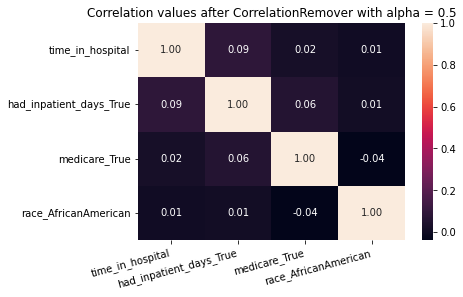

In [52]:
plot_correlation_heatmap(X_cr_alpha, f"Correlation values after CorrelationRemover with alpha = 0.5")

In [53]:
X_raw

,time_in_hospital,had_inpatient_days_True,medicare_True,race_AfricanAmerican
0,1,0,0,0
1,3,0,0,0
2,2,1,0,1
3,2,0,0,0
4,1,0,0,0
...,...,...,...,...
101761,3,0,1,1
101762,5,1,1,1
101763,1,0,1,0
101764,10,1,1,0


In [54]:
X_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 4 columns):
 #   Column                   Non-Null Count   Dtype
---  ------                   --------------   -----
 0   time_in_hospital         101766 non-null  int64
 1   had_inpatient_days_True  101766 non-null  uint8
 2   medicare_True            101766 non-null  uint8
 3   race_AfricanAmerican     101766 non-null  uint8
dtypes: int64(1), uint8(3)
memory usage: 1.1 MB


In [55]:
y

0         0
1         0
2         0
3         0
4         0
         ..
101761    0
101762    0
101763    0
101764    0
101765    0
Name: readmit_30_days, Length: 101766, dtype: int64

/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='readmit_30_days', ylabel='count'>

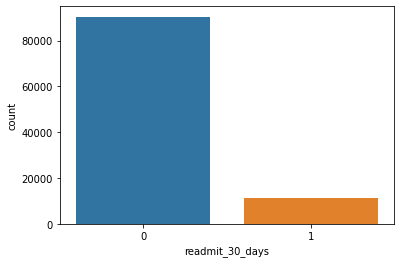

In [56]:
sns.countplot(y)

In [57]:
y.value_counts(normalize=True)

0    0.888401
1    0.111599
Name: readmit_30_days, dtype: float64

In [58]:
X_raw.isnull().values.any()

False

In [59]:
y.isnull().values.any()

False

In [60]:
X_raw.columns

Index(['time_in_hospital', 'had_inpatient_days_True', 'medicare_True',
       'race_AfricanAmerican'],
      dtype='object')

measure performance

In [61]:
X = X_raw

# Split the data into training and test sets, with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=0, stratify=y)

# save sensetive examples map vector
X_train_sensitive = X_train[sensitive_attr]
X_test_sensitive =  X_test[sensitive_attr]
# drop sensitive column from train data
X_train = X_train.drop(sensitive_attr, axis=1)
X_test = X_test.drop(sensitive_attr, axis=1)
X_train.columns

Index(['time_in_hospital', 'had_inpatient_days_True', 'medicare_True'], dtype='object')

In [62]:
X_train_sensitive.sample(3)

21105    0
86176    0
52838    0
Name: race_AfricanAmerican, dtype: uint8

In [63]:
X_test.sample(2)

,time_in_hospital,had_inpatient_days_True,medicare_True
15097,11,0,0
10885,2,0,0


In [64]:
# evaluate a model
def evaluate_model(X, y, model, scoring='accuracy'):
	# define evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate model
	scores = cross_val_score(model, X, y, scoring=scoring, cv=cv, n_jobs=-1)
	return np.mean(scores)

In [65]:
# baseline majority
dummy_model = DummyClassifier(strategy='most_frequent')
dummy_model.fit(X_train, y_train)

# Predict on the test data
y_pred_dummy = dummy_model.predict(X_test)

# evaluate the model
score = dummy_model.score(X_test, y_test)
score # makes sense due to stratification


0.8884248796305394

In [66]:
print(classification_report(y_test, y_pred_dummy))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94     18083
           1       0.00      0.00      0.00      2271

    accuracy                           0.89     20354
   macro avg       0.44      0.50      0.47     20354
weighted avg       0.79      0.89      0.84     20354



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [67]:
geometric_mean_score(y_test, y_pred_dummy, pos_label=1, average='binary')

0.0

In [68]:
# Create logistic regression object
logreg = LogisticRegression(class_weight='balanced')

# Train the model on the training data
logreg.fit(X_train, y_train)

# Predict on the test data
y_pred_orig = logreg.predict(X_test)

# Calculate the accuracy score on the test data
accuracy = logreg.score(X_test, y_test)

# Print the accuracy score
print("logreg accuracy:", accuracy)

logreg accuracy: 0.6503389997052177


In [69]:
print(classification_report(y_test, y_pred_orig))

              precision    recall  f1-score   support

           0       0.92      0.67      0.77     18083
           1       0.16      0.52      0.25      2271

    accuracy                           0.65     20354
   macro avg       0.54      0.59      0.51     20354
weighted avg       0.83      0.65      0.71     20354



In [70]:
roc_auc_score(y_test, y_pred_orig)

0.5916367268079112

In [71]:
geometric_mean_score(y_test, y_pred_orig, pos_label=1, average='binary')

0.5867912925781841

In [72]:
# measure performance after corr removal alpha=1
X = X_cr

# Split the data into training and test sets, with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=0, stratify=y)

In [73]:
X_cr.sample(2)

,time_in_hospital,had_inpatient_days_True,medicare_True,race_AfricanAmerican
28844,4.026032,0.004655,0.982238,0
39260,4.026032,0.004655,0.982238,0


In [74]:
# Create logistic regression object
logreg_cr = LogisticRegression(class_weight='balanced')

# Train the model on the training data
logreg_cr.fit(X_train, y_train)

# Predict on the test data
y_pred_cr = logreg_cr.predict(X_test)

# Calculate the accuracy score on the test data
accuracy = logreg_cr.score(X_test, y_test)

# Print the accuracy score
print("logreg_cr accuracy:", accuracy)

logreg_cr accuracy: 0.6515672595067309


In [75]:
print(classification_report(y_test, y_pred_cr))

              precision    recall  f1-score   support

           0       0.92      0.67      0.77     18083
           1       0.16      0.51      0.25      2271

    accuracy                           0.65     20354
   macro avg       0.54      0.59      0.51     20354
weighted avg       0.83      0.65      0.71     20354



In [76]:
roc_auc_score(y_test, y_pred_cr)

0.5913653985501025

In [77]:
geometric_mean_score(y_test, y_pred_cr, pos_label=1, average='binary')

0.5862657944570931

In [78]:
np.array_equal(y_pred_orig, y_pred_cr)

False

In [79]:
# measure fairness
from fairlearn.metrics import equalized_odds_difference, demographic_parity_difference

In [80]:
y_test.shape

(20354,)

In [81]:
y_pred_orig.shape

(20354,)

In [82]:
# fairness of logreg on original data 
print(f'equalized_odds_difference: {equalized_odds_difference(y_test, y_pred_orig, sensitive_features=X_test_sensitive)}')
print(f'demographic_parity_difference: {demographic_parity_difference(y_test, y_pred_orig, sensitive_features=X_test_sensitive)}')

equalized_odds_difference: 0.050273497126486544
demographic_parity_difference: 0.02709867590654036


In [83]:
# fairness of logreg on cr data 
print(f'equalized_odds_difference: {equalized_odds_difference(y_test, y_pred_cr, sensitive_features=X_test_sensitive)}')
print(f'demographic_parity_difference: {demographic_parity_difference(y_test, y_pred_cr, sensitive_features=X_test_sensitive)}')

equalized_odds_difference: 0.03896127993191634
demographic_parity_difference: 0.01805474825796155


In [ ]:
# it is shown that cr does not worsen performance although helping fairness 